In [ ]:
#import essential libraries and framework
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

Matplotlib is building the font cache; this may take a moment.


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [6]:
def ResNet18():
    return ResNet(ResidualBlock)

In [7]:
#Use the ResNet18 on MNIST
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os

#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set hyperparameter
EPOCH = 10
pre_epoch = 0
BATCH_SIZE = 128
LR = 0.01

#prepare dataset and preprocessing (MNIST -> make 3x32x32 to match network)
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))
])

trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

#labels in MNIST
classes = tuple(str(i) for i in range(10))

#define ResNet18
net = ResNet18().to(device)

#define loss funtion & optimize
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)

Labels: 4 9 0 2 2 7 4 2 2 2 8 1 5 3 6 4 6 4 1 3 1 2 2 1 9 1 9 3 1 5 7 5


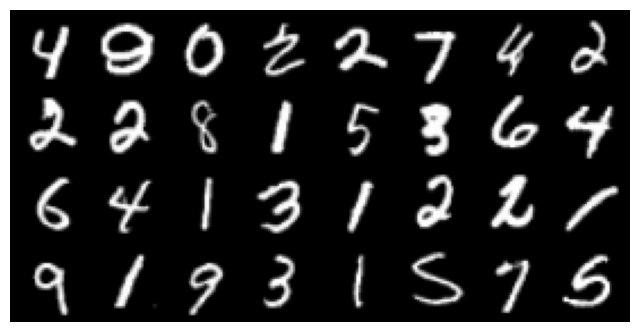

In [8]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images[:32].clone()
images = images * 0.3081 + 0.1307
grid = make_grid(images, nrow=8, padding=2)
npimg = grid.cpu().numpy()
npimg = np.transpose(npimg, (1, 2, 0))
plt.figure(figsize=(8, 8))
plt.imshow(npimg)
plt.axis('off')
print('Labels:', ' '.join([classes[l.item()] for l in labels[:32]]))

In [6]:
#train
for epoch in range(pre_epoch, EPOCH):
    print('\nEpoch: %d' % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        #prepare dataset
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        #forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print ac & loss in each batch
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
              % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))

    #get the ac with testdataset in each epoch
    print('Waiting Test...')
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print('Test\'s ac is: %.3f%%' % (100 * correct / total))

print('Train has finished, total epoch is %d' % EPOCH)


Epoch: 1
[epoch:1, iter:1] Loss: 2.374 | Acc: 12.500% 
[epoch:1, iter:2] Loss: 2.318 | Acc: 12.109% 
[epoch:1, iter:3] Loss: 2.275 | Acc: 14.844% 
[epoch:1, iter:4] Loss: 2.233 | Acc: 16.992% 
[epoch:1, iter:5] Loss: 2.186 | Acc: 20.938% 
[epoch:1, iter:6] Loss: 2.126 | Acc: 23.958% 
[epoch:1, iter:7] Loss: 2.076 | Acc: 26.674% 
[epoch:1, iter:8] Loss: 2.040 | Acc: 28.027% 
[epoch:1, iter:9] Loss: 1.980 | Acc: 31.424% 
[epoch:1, iter:10] Loss: 1.913 | Acc: 35.547% 
[epoch:1, iter:11] Loss: 1.861 | Acc: 37.713% 
[epoch:1, iter:12] Loss: 1.799 | Acc: 40.365% 
[epoch:1, iter:13] Loss: 1.750 | Acc: 42.368% 
[epoch:1, iter:14] Loss: 1.690 | Acc: 44.587% 
[epoch:1, iter:15] Loss: 1.631 | Acc: 46.510% 
[epoch:1, iter:16] Loss: 1.584 | Acc: 48.047% 
[epoch:1, iter:17] Loss: 1.533 | Acc: 50.046% 
[epoch:1, iter:18] Loss: 1.485 | Acc: 51.910% 
[epoch:1, iter:19] Loss: 1.434 | Acc: 53.783% 
[epoch:1, iter:20] Loss: 1.389 | Acc: 55.430% 
[epoch:1, iter:21] Loss: 1.343 | Acc: 57.143% 
[epoch:1, it

2.9.0+cu126
2.0.2
